In [404]:
import pandas as pd 
from Utils.Read_data import *
import os
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import shap

In [64]:
path = "DataPaper/"
users = os.listdir(path)

In [75]:
Actigraphy_labelled = pd.read_csv("DataPaper/actigraph_labelled.csv")

In [77]:
Actigraphy_labelled['user'] = Actigraphy_labelled['user'].str.replace('user_', '').astype(int)

In [79]:
user = np.array(Actigraphy_labelled['user'])

user_ends = list(np.where(user[:-1] != user[1:])[0])
user_ends.append(len(user)-1)

user_starts = [0]
user_starts.extend([i+1 for i in user_ends[:-1]])

In [90]:
Actigraphy_labelled['time'] = pd.to_datetime(Actigraphy_labelled['time']).dt.time

C:\Users\anisr\AppData\Local\Temp\ipykernel_18056\1618958388.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Actigraphy_labelled['time'] = pd.to_datetime(Actigraphy_labelled['time']).dt.time


In [91]:
start_list = []
end_list = []

for idx in range(len(user_starts)):

    for i in range(user_starts[idx], user_ends[idx]+1):
        if i == user_starts[idx]:
            start_list.append(i)
            start_time = Actigraphy_labelled.time.iloc[i]
            end_time = (dt.datetime.combine(dt.date(1, 1, 1),
                        start_time) + dt.timedelta(minutes=5)).time()
        elif i != user_ends[idx]:
            if Actigraphy_labelled.time.iloc[i] >= end_time:
                start_time = Actigraphy_labelled.time.iloc[i]
                end_time = (dt.datetime.combine(dt.date(1, 1, 1),
                            start_time) + dt.timedelta(minutes=5)).time()
                end_list.append(i-1)
                start_list.append(i)
            elif i >= (start_list[-1]+300):
                start_time = Actigraphy_labelled.time.iloc[i]
                end_time = (dt.datetime.combine(dt.date(1, 1, 1),
                            start_time) + dt.timedelta(minutes=5)).time()
                end_list.append(i-1)
                start_list.append(i)

        else:
            end_list.append(i)
            print(i)

68434
129643
201360
271099
338450
415085
487978
559384
631181
700524
769351
832721
901408
971298
1039595
1107855
1180032
1252177
1319584
1388798
1454156
1519257


In [92]:
Actigraphy_labelled['Activity'] = Actigraphy_labelled['Activity'].astype(str)

activity_intervals = []
mean_intervals = []
std_mag = []
interval_starts = []

for i, j in zip(start_list, end_list):
    act = np.unique(Actigraphy_labelled.Activity.iloc[i:j])
    if len(act) == 1:
        activity_intervals.append(act[0])

        numeric_data = Actigraphy_labelled.iloc[i:j].select_dtypes(include=[
                                                                   np.number])
        mean_intervals.append(numeric_data.mean())

        std_mag.append(
            np.std(Actigraphy_labelled['Vector Magnitude'].iloc[i:j]))
        interval_starts.append(i)

interval_ends = [end_list[start_list.index(i)] for i in interval_starts]

df = pd.DataFrame(mean_intervals)
df['Mag_std'] = std_mag
df['Activity'] = activity_intervals
df['n_rows'] = np.array(interval_ends) - np.array(interval_starts)
df['start_time'] = [Actigraphy_labelled.time.iloc[i] for i in interval_starts]
df['end_time'] = [Actigraphy_labelled.time.iloc[i] for i in interval_ends]

df = df[(df['n_rows'] <= 300) & (df['n_rows'] >= 180)]
df

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,Day,user,Mag_std,Activity,n_rows,start_time,end_time
0,61.774436,71.304000,89.878788,1.031250,98.500000,1.0,1.0,1.0,1.0,127.429660,1.0,1.0,106.780618,sitting,186,10:10:22,10:15:21
1,51.416667,66.644628,77.201258,1.092308,89.379592,1.0,1.0,1.0,1.0,107.670339,1.0,1.0,88.538379,sitting,245,10:15:22,10:20:21
2,67.731579,62.189474,82.119403,1.201754,93.065306,1.0,1.0,1.0,1.0,125.522476,1.0,1.0,75.338800,sleeping,245,10:25:22,10:30:21
3,46.918605,59.787500,68.660000,1.230769,84.795918,NaN,1.0,1.0,1.0,103.434706,1.0,1.0,77.627131,sleeping,245,10:30:22,10:35:21
4,38.838926,47.926471,45.789809,1.014286,106.349794,1.0,1.0,1.0,1.0,76.016529,1.0,1.0,66.110434,sleeping,243,10:45:26,10:50:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,NaN,NaN,NaN,NaN,53.080169,1.0,NaN,NaN,NaN,NaN,-29.0,9.0,NaN,sleeping,237,08:45:24,08:50:23
5352,NaN,NaN,NaN,NaN,59.814815,1.0,NaN,NaN,NaN,NaN,-29.0,9.0,NaN,sleeping,243,08:50:24,08:55:23
5353,NaN,NaN,NaN,NaN,57.914286,1.0,NaN,NaN,NaN,NaN,-29.0,9.0,NaN,sleeping,245,08:55:24,09:00:23
5354,NaN,NaN,NaN,NaN,71.955947,1.0,NaN,NaN,NaN,NaN,-29.0,9.0,NaN,sleeping,227,09:00:24,09:05:23


In [93]:
categorical_columns = df.select_dtypes(include=['object']).columns
continuous_columns = df.select_dtypes(include=['float64']).columns

In [94]:
df[categorical_columns] = df[categorical_columns].fillna(0)

In [95]:
df['Day'].value_counts()

Day
 1.000000     3143
 2.000000     1896
-29.000000     189
 1.995918        6
-28.877551       2
 1.995885        1
 1.995902        1
 1.995614        1
 1.996000        1
 1.995833        1
Name: count, dtype: int64

In [96]:
df[continuous_columns] = df[continuous_columns].fillna(
    df[continuous_columns].mean())
df['Day'] = df['Day'].apply(
    lambda x: 2 if x in [2, -29.000000, -28.877551] else 1)

In [97]:
df['Day'].value_counts()

Day
1    3156
2    2085
Name: count, dtype: int64

In [98]:
df

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,Day,user,Mag_std,Activity,n_rows,start_time,end_time
0,61.774436,71.304000,89.878788,1.031250,98.500000,1.0,1.0,1.0,1.0,127.429660,1,1.0,106.780618,sitting,186,10:10:22,10:15:21
1,51.416667,66.644628,77.201258,1.092308,89.379592,1.0,1.0,1.0,1.0,107.670339,1,1.0,88.538379,sitting,245,10:15:22,10:20:21
2,67.731579,62.189474,82.119403,1.201754,93.065306,1.0,1.0,1.0,1.0,125.522476,1,1.0,75.338800,sleeping,245,10:25:22,10:30:21
3,46.918605,59.787500,68.660000,1.230769,84.795918,1.0,1.0,1.0,1.0,103.434706,1,1.0,77.627131,sleeping,245,10:30:22,10:35:21
4,38.838926,47.926471,45.789809,1.014286,106.349794,1.0,1.0,1.0,1.0,76.016529,1,1.0,66.110434,sleeping,243,10:45:26,10:50:23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,48.464950,49.122275,52.442560,1.066920,53.080169,1.0,1.0,1.0,1.0,81.807228,2,9.0,66.397241,sleeping,237,08:45:24,08:50:23
5352,48.464950,49.122275,52.442560,1.066920,59.814815,1.0,1.0,1.0,1.0,81.807228,2,9.0,66.397241,sleeping,243,08:50:24,08:55:23
5353,48.464950,49.122275,52.442560,1.066920,57.914286,1.0,1.0,1.0,1.0,81.807228,2,9.0,66.397241,sleeping,245,08:55:24,09:00:23
5354,48.464950,49.122275,52.442560,1.066920,71.955947,1.0,1.0,1.0,1.0,81.807228,2,9.0,66.397241,sleeping,227,09:00:24,09:05:23


In [99]:
activity_dummies = pd.get_dummies(df['Activity'], dtype=int)
Activity_intervals = pd.concat([df, activity_dummies], axis=1)

In [100]:
Activity_intervals

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,...,large screen,laying down,light movement,medium movement,nan,saliva samples,sitting,sleeping,small screen usage,smoking
0,61.774436,71.304000,89.878788,1.031250,98.500000,1.0,1.0,1.0,1.0,127.429660,...,0,0,0,0,0,0,1,0,0,0
1,51.416667,66.644628,77.201258,1.092308,89.379592,1.0,1.0,1.0,1.0,107.670339,...,0,0,0,0,0,0,1,0,0,0
2,67.731579,62.189474,82.119403,1.201754,93.065306,1.0,1.0,1.0,1.0,125.522476,...,0,0,0,0,0,0,0,1,0,0
3,46.918605,59.787500,68.660000,1.230769,84.795918,1.0,1.0,1.0,1.0,103.434706,...,0,0,0,0,0,0,0,1,0,0
4,38.838926,47.926471,45.789809,1.014286,106.349794,1.0,1.0,1.0,1.0,76.016529,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5351,48.464950,49.122275,52.442560,1.066920,53.080169,1.0,1.0,1.0,1.0,81.807228,...,0,0,0,0,0,0,0,1,0,0
5352,48.464950,49.122275,52.442560,1.066920,59.814815,1.0,1.0,1.0,1.0,81.807228,...,0,0,0,0,0,0,0,1,0,0
5353,48.464950,49.122275,52.442560,1.066920,57.914286,1.0,1.0,1.0,1.0,81.807228,...,0,0,0,0,0,0,0,1,0,0
5354,48.464950,49.122275,52.442560,1.066920,71.955947,1.0,1.0,1.0,1.0,81.807228,...,0,0,0,0,0,0,0,1,0,0


In [101]:
RR_df = create_dataset(users,'RR')

NO data for actigraph_expanded.csv
NO data for actigraph_intervals.csv
NO data for actigraph_labelled.csv
NO data for activity_rr.csv
NO data for df_rr_2_activity.csv
NO data for group1.csv
NO data for group2.csv


In [109]:
RR_df

,ibi_s,day,time,user
0,0.258,1,10:10:17,user_1
1,0.319,1,10:10:18,user_1
2,0.266,1,10:10:18,user_1
3,0.401,1,10:10:18,user_1
4,1.089,1,10:10:19,user_1
...,...,...,...,...
75245,0.686,-29,09:24:19,user_9
75246,0.673,-29,09:24:20,user_9
75247,0.664,-29,09:24:20,user_9
75248,0.667,-29,09:24:21,user_9


In [111]:
RR_df['user'] = RR_df['user'].str.replace(
    'user_', '').astype(int)

In [114]:
RR_df['time'] = pd.to_datetime(
    RR_df['time']).dt.time

C:\Users\anisr\AppData\Local\Temp\ipykernel_18056\1888468138.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  RR_df['time'] = pd.to_datetime(


In [118]:
RR_df['day'] = RR_df['day'].apply(
    lambda x: 2 if x in [2, -29.000000, -28.877551] else 1)
RR_df['day'].value_counts()

day
1    1162743
2     586552
Name: count, dtype: int64

In [121]:
AI_idx = []
RRs = []
for day, user, start, end, idx in zip(Activity_intervals.Day, Activity_intervals.user,
                                      Activity_intervals.start_time, Activity_intervals.end_time, Activity_intervals.index):
    AI_idx.append(idx)
    RR_list = []
    for RR_day, RR_user, RR_time, RR_RR in zip(RR_df.day, RR_df.user, RR_df.time, RR_df.ibi_s):
        if (RR_user == user) and (RR_day == day) and (RR_time > start) and (RR_time < end):
            RR_list.append(RR_RR)
    RRs.append(RR_list)

In [108]:
RR_user

'user_9'

In [124]:
filtered_RRs = []
for series in RRs:
    filtered = [i for i in series if ((i > 0.3) & (i < 3))]
    filtered_mean = np.mean(filtered)
    filtered_std = np.std(filtered)
    lower = filtered_mean-filtered_std
    upper = filtered_mean+filtered_std
    filtered_RRs.append([i for i in filtered if ((i >= lower) & (i <= upper))])

c:\Users\anisr\anaconda3\envs\research\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [126]:
def RMSSD(RR_list):
    return np.sqrt(np.sum((np.diff((np.array(RR_list)*1000))**2)/(len(RR_list)-1)))

In [127]:
RMSSDs = [RMSSD(series) for series in filtered_RRs]

Activity_intervals['RMSSD'] = RMSSDs

Activity_intervals = Activity_intervals[Activity_intervals['RMSSD'] != 0]

In [130]:
Activity_intervals.columns

Index(['Axis1', 'Axis2', 'Axis3', 'Steps', 'HR', 'Inclinometer Off',
       'Inclinometer Standing', 'Inclinometer Sitting', 'Inclinometer Lying',
       'Vector Magnitude', 'Day', 'user', 'Mag_std', 'Activity', 'n_rows',
       'start_time', 'end_time', 'alcohol assumption', 'coffee/coke', 'eating',
       'heavy movement', 'large screen', 'laying down', 'light movement',
       'medium movement', 'nan', 'saliva samples', 'sitting', 'sleeping',
       'small screen usage', 'smoking', 'RMSSD'],
      dtype='object')

In [171]:
df_saliva = create_dataset(users, 'Saliva')

NO data for actigraph_expanded.csv
NO data for actigraph_intervals.csv
NO data for actigraph_labelled.csv
NO data for activity_rr.csv
NO data for df_rr_2_activity.csv
NO data for group1.csv
NO data for group2.csv
NO data for user_21


In [173]:
df_saliva.to_csv('DataPaper/saliva.csv', index=False)

In [275]:
df_sleep = create_dataset(users, 'Sleep')

NO data for actigraph_expanded.csv
NO data for actigraph_intervals.csv
NO data for actigraph_labelled.csv
NO data for activity_rr.csv
NO data for df_rr_2_activity.csv
NO data for group1.csv
NO data for group2.csv


In [279]:
df_sleep = df_sleep[['Efficiency','Number of Awakenings','Wake After Sleep Onset (WASO)','Total Sleep Time (TST)','user']]
df_sleep['user'] = df_sleep['user'].str.replace(
    'user_', '').astype(int)

In [302]:
df_sleep = df_sleep.astype('float64')

In [174]:
Activity_intervals.to_csv("DataPaper/Activity_classification.csv", index=False)

In [303]:
before_sleep = df_saliva[df_saliva['SAMPLES']=='before sleep']
after_sleep = df_saliva[df_saliva['SAMPLES'] == 'wake up']

In [304]:
combined_sleep = pd.merge(before_sleep, after_sleep, on='user', suffixes=('_before_sleep', '_after_sleep'))

combined_sleep.drop(['SAMPLES_before_sleep', 'SAMPLES_after_sleep'], axis=1, inplace=True)

In [305]:
combined_sleep.fillna(combined_sleep['Melatonin NORM_after_sleep'].mean(),inplace=True)

In [306]:
combined_sleep['user'] = combined_sleep['user'].str.replace(
    'user_', '').astype(int)

In [307]:
df_ = pd.merge(Activity_intervals, combined_sleep, on=['user']).sample(frac=1).reset_index(drop=True)

In [308]:
df_ = pd.merge(df_, df_sleep, on='user').sample(frac=1).reset_index(drop=True)

In [309]:
df_.columns

Index(['Axis1', 'Axis2', 'Axis3', 'Steps', 'HR', 'Inclinometer Off',
       'Inclinometer Standing', 'Inclinometer Sitting', 'Inclinometer Lying',
       'Vector Magnitude', 'Day', 'user', 'Mag_std', 'Activity', 'n_rows',
       'start_time', 'end_time', 'alcohol assumption', 'coffee/coke', 'eating',
       'heavy movement', 'large screen', 'laying down', 'light movement',
       'medium movement', 'nan', 'saliva samples', 'sitting', 'sleeping',
       'small screen usage', 'smoking', 'RMSSD', 'Cortisol NORM_before_sleep',
       'Melatonin NORM_before_sleep', 'Cortisol NORM_after_sleep',
       'Melatonin NORM_after_sleep', 'Efficiency', 'Number of Awakenings',
       'Wake After Sleep Onset (WASO)', 'Total Sleep Time (TST)'],
      dtype='object')

In [310]:

X_features = ['Efficiency', 'Number of Awakenings',
              'Wake After Sleep Onset (WASO)', 'Total Sleep Time (TST)', 'HR', 'Steps', 'Inclinometer Standing', 'Inclinometer Sitting', 'Inclinometer Lying',
              'Vector Magnitude', 'RMSSD', 'Cortisol NORM_before_sleep',
              'Melatonin NORM_before_sleep', 'Cortisol NORM_after_sleep',
              'Melatonin NORM_after_sleep']

y_labels = ['alcohol assumption', 'coffee/coke', 'eating',
            'heavy movement', 'large screen', 'laying down', 'light movement',
       'medium movement', 'nan', 'saliva samples', 'sitting', 'sleeping',
       'small screen usage', 'smoking',]

X_all = df_[X_features]
y_all = df_[y_labels]

y_rest = y_all[(y_all['laying down'] > 0) |
               (y_all['sitting'] > 0)].index.tolist()

y_stress = y_all[(y_all['heavy movement'] > 0) |
                 (y_all['alcohol assumption'] > 0) |
                 (y_all['smoking'] > 0)].index.tolist()

In [311]:
X = pd.concat([X_all[X_all.index.isin(y_rest)], X_all[X_all.index.isin(y_stress)]])

In [312]:
y = []
y.extend([0]*len(y_rest))
y.extend([1]*len(y_stress))

In [313]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

smote = SMOTE(sampling_strategy='minority')
X_smoted, y_smoted = smote.fit_resample(X, y)

X_train, X_val, y_train, y_val = train_test_split(
    X_smoted, y_smoted, test_size=0.1)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.11)

In [412]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'DecisionTree': DecisionTreeClassifier()
}

param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0]
    },
    'DecisionTree': {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
}

best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name} with GridSearchCV...")
    pipeline = Pipeline([
        ('classifier', model)
    ])
    grid_search = GridSearchCV(
        pipeline, param_grids[model_name], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters for {model_name}: {best_params}")
    y_pred = best_models[model_name].predict(X_test)
    print(f"Accuracy for {model_name}: {accuracy_score(y_test, y_pred)}")

Training RandomForest with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Accuracy for RandomForest: 0.9574468085106383
Training XGBoost with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[00:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Best parameters for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Accuracy for XGBoost: 0.9893617021276596
Training DecisionTree with GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for DecisionTree: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy for DecisionTree: 0.9787234042553191


In [413]:
pipelines = {}
shap_values_dict = {}
explainers = {}

In [414]:
for model_name, model in models.items():
    pipelines[model_name] = Pipeline([
        ('classifier', model)
    ])
    print(f"Training {model_name}...")
    pipelines[model_name].fit(X_train, y_train)

    if model_name == 'XGBoost':
        explainer = shap.Explainer(
            pipelines[model_name].named_steps['classifier'])
    else:
        explainer = shap.TreeExplainer(
            pipelines[model_name].named_steps['classifier'])

    explainers[model_name] = explainer
    shap_values = explainer.shap_values(X_test)
    shap_values_dict[model_name] = shap_values

Training RandomForest...
Training XGBoost...


[00:12:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Training DecisionTree...


Model: RandomForest
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        47
           1       1.00      0.94      0.97        47

    accuracy                           0.97        94
   macro avg       0.97      0.97      0.97        94
weighted avg       0.97      0.97      0.97        94

Model: XGBoost
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.98      0.99        47

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       0.99      0.99      0.99        94

Model: DecisionTree
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.98      0.99        47

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       

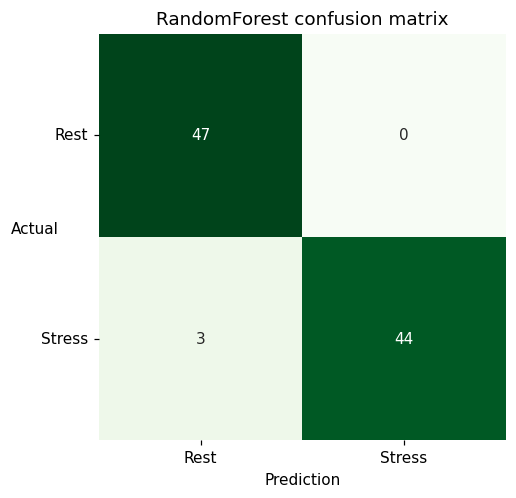

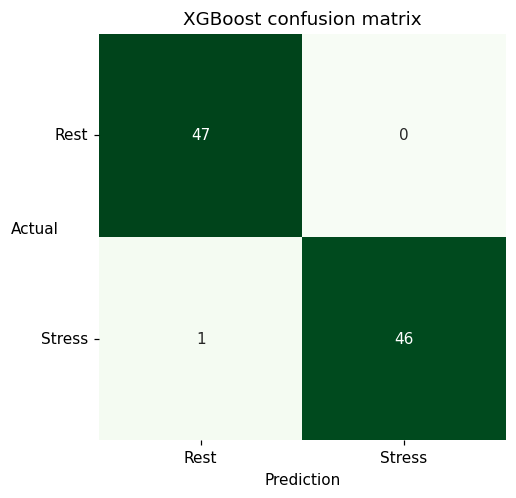

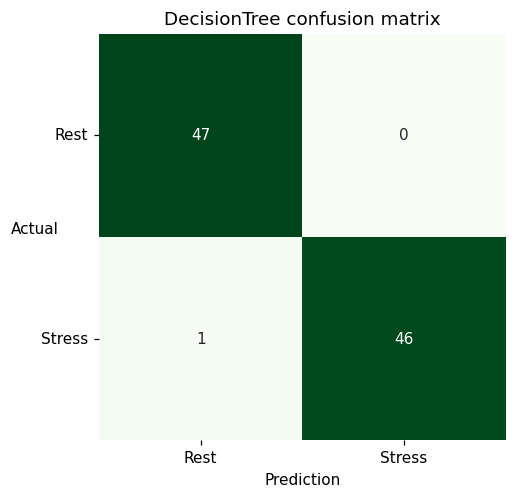

In [ ]:
for model_name, model in pipelines.items():
    y_preds = model.predict(X_test)
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_preds))

    cf_matrix = confusion_matrix(y_test, y_preds)
    plt.figure(dpi=110)
    sns.heatmap(cf_matrix, cmap=plt.cm.Greens, annot=True, square=True, fmt='g',
                xticklabels=['Rest', 'Stress'],
                yticklabels=['Rest', 'Stress'],
                cbar=False)
    plt.yticks(rotation=0)
    plt.xlabel('Prediction')
    plt.ylabel('Actual', rotation=0)
    plt.title(f'{model_name} confusion matrix')


In [407]:
user_1_RR = RR_df[RR_df['user'] == 1]

In [355]:
times = []
u1RRs = []
for i in range(len(user_1_RR)):
    current_time = pd.to_datetime(
        user_1_RR.time.iloc[i], format='%H:%M:%S').time()
    if i == 0:
        start_time = current_time
        end_time = (dt.datetime.combine(dt.date(1, 1, 1),
                    start_time) + dt.timedelta(minutes=1)).time()
        times.append(current_time)
        tmp_RRs = []
        tmp_RRs.append(user_1_RR.ibi_s.iloc[i])
    elif current_time >= end_time:
        times.append(current_time)
        start_time = current_time
        end_time = (dt.datetime.combine(dt.date(1, 1, 1),
                    start_time) + dt.timedelta(minutes=1)).time()
        tmp_RRs = []
        tmp_RRs.append(user_1_RR.ibi_s.iloc[i])
        u1RRs.append(tmp_RRs)
    elif i == (len(user_1_RR)-1):
        u1RRs.append(tmp_RRs)
    else:
        tmp_RRs.append(user_1_RR.ibi_s.iloc[i])

In [356]:
len(times) , len(u1RRs)

(1278, 1278)

In [357]:
u1_filtered_RRs = []
for series in u1RRs:
    filtered = [i for i in series if ((i > 0.3) & (i < 3))]
    filtered_mean = np.mean(filtered)
    filtered_std = np.std(filtered)
    lower = filtered_mean-filtered_std
    upper = filtered_mean+filtered_std
    u1_filtered_RRs.append(
        [i for i in filtered if ((i >= lower) & (i <= upper))])

In [358]:
u1RMSSDs = [RMSSD(series) for series in u1_filtered_RRs]

In [359]:
len(u1RMSSDs)

1278

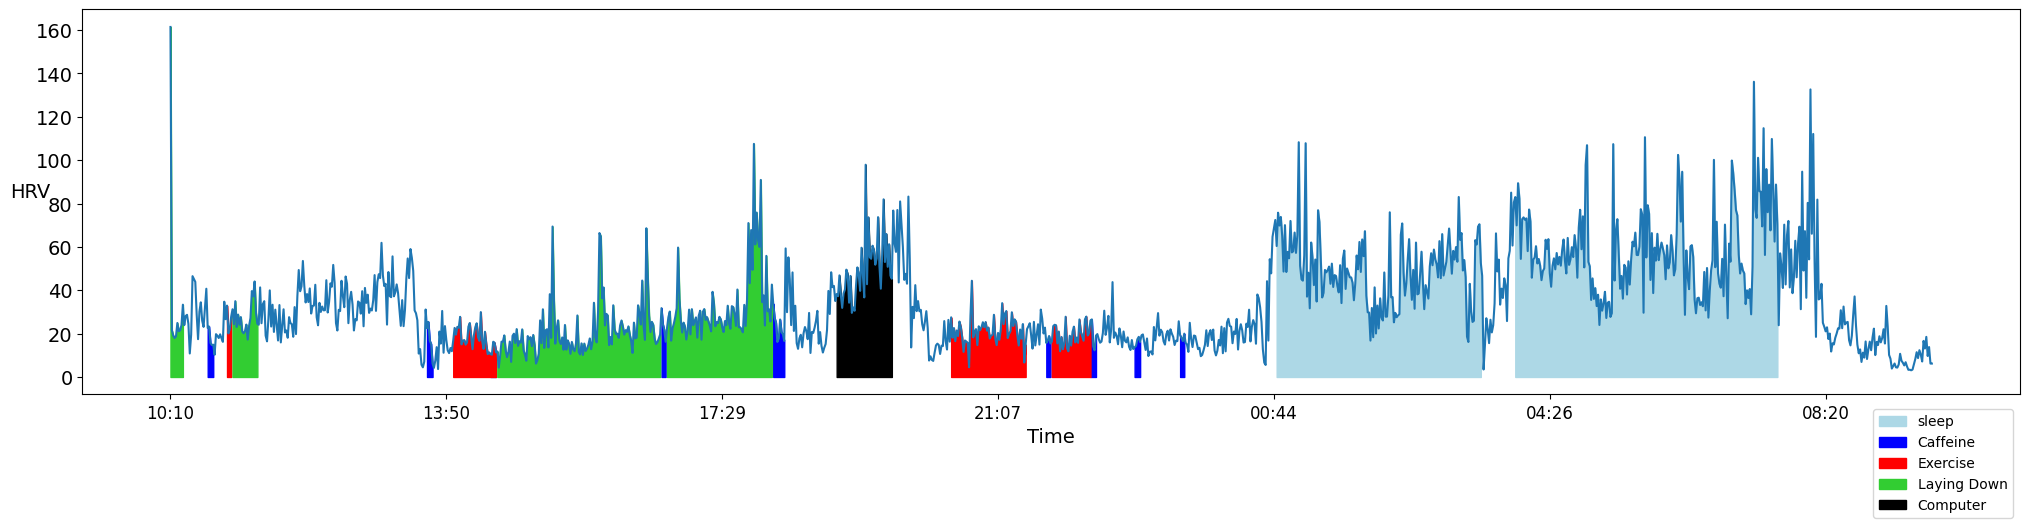

In [408]:
time_ticks = []
for i in np.arange(0, 1300, 200):
    time_ticks.append(times[i].strftime('%H:%M'))

x = np.arange(0, 1278, 1)
plt.figure(figsize=(25, 5))
plt.plot(x, u1RMSSDs)

plt.fill_between(x,u1RMSSDs,0, where=(x>=802)&(x<951), color='lightblue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=975)&(x<1166), color='lightblue', label='sleep')

plt.fill_between(x,u1RMSSDs,0, where=(x>=27)&(x<32), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=186)&(x<191), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=232)&(x<237), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=356)&(x<360), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=437)&(x<446), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=635)&(x<639), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=667)&(x<672), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=699)&(x<704), color='blue')
plt.fill_between(x,u1RMSSDs,0, where=(x>=732)&(x<736), color='blue', label='Caffeine')

plt.fill_between(x,u1RMSSDs,0, where=(x>=41)&(x<45), color='red')
plt.fill_between(x,u1RMSSDs,0, where=(x>=205)&(x<237), color='red')
plt.fill_between(x,u1RMSSDs,0, where=(x>=566)&(x<621), color='red')
plt.fill_between(x,u1RMSSDs,0, where=(x>=639)&(x<668), color='red', label='Exercise')

plt.fill_between(x,u1RMSSDs,0, where=(x>=0)&(x<10), color='limegreen')
plt.fill_between(x,u1RMSSDs,0, where=(x>=45)&(x<64), color='limegreen')
plt.fill_between(x,u1RMSSDs,0, where=(x>=237)&(x<356), color='limegreen')
plt.fill_between(x,u1RMSSDs,0, where=(x>=360)&(x<437), color='limegreen', label='Laying Down')

plt.fill_between(x,u1RMSSDs,0, where=(x>=483)&(x<524), color='black', label='Computer')


plt.legend(bbox_to_anchor=(1, -.02), fontsize=10)
plt.xlabel('Time', fontsize=14)
plt.ylabel('HRV', fontsize=14, rotation=0)
plt.yticks(fontsize=14)
plt.xticks(np.arange(0, 1300, 200), time_ticks, fontsize=12);

In [334]:
shap.initjs()

SHAP Summary for RandomForest:


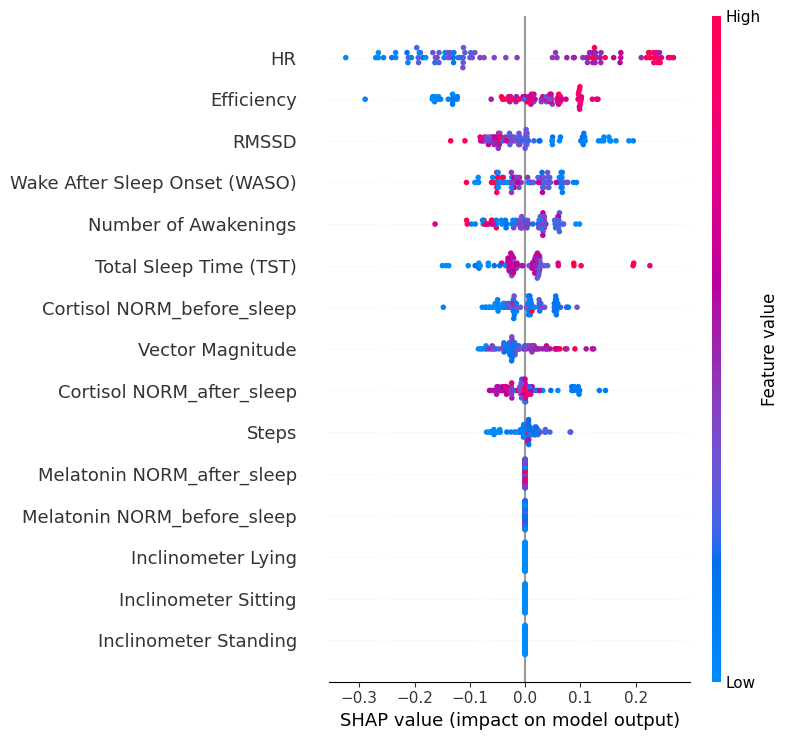

SHAP Summary for XGBoost:


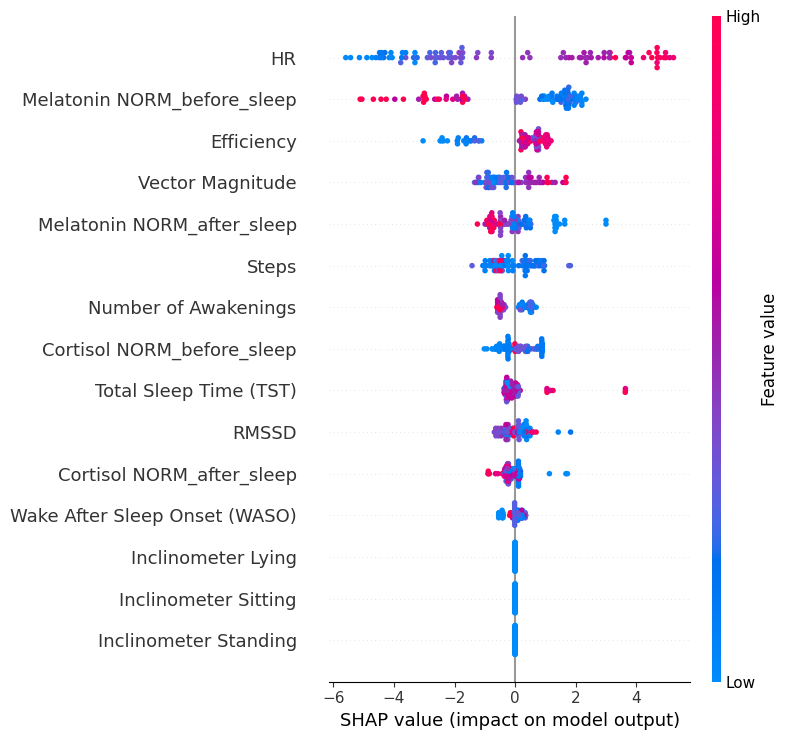

SHAP Summary for DecisionTree:


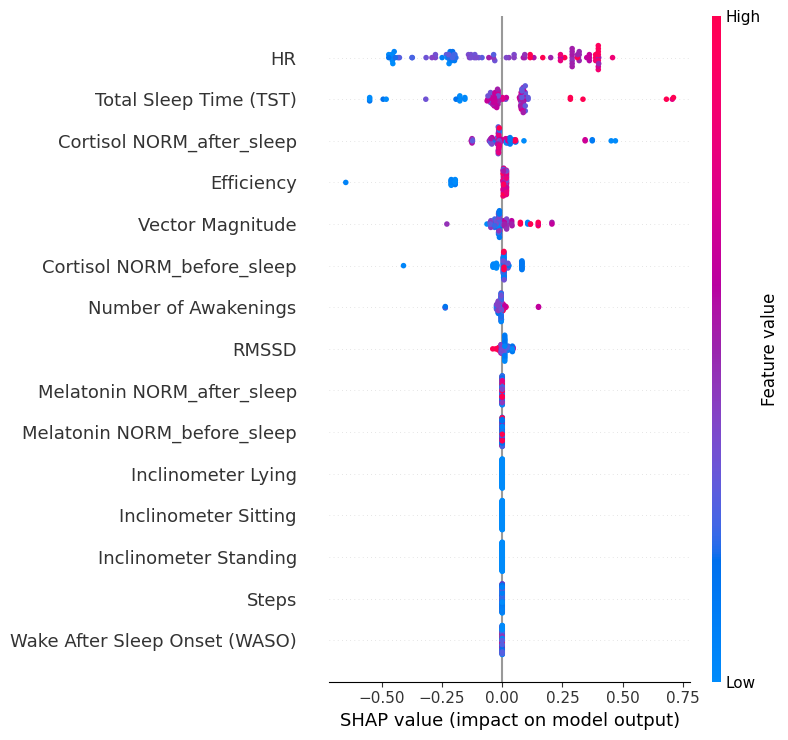

In [416]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    if model_name == 'XGBoost':
        shap.summary_plot(shap_values, X_test)
    else:
        shap.summary_plot(shap_values[1], X_test)

SHAP Summary for RandomForest:


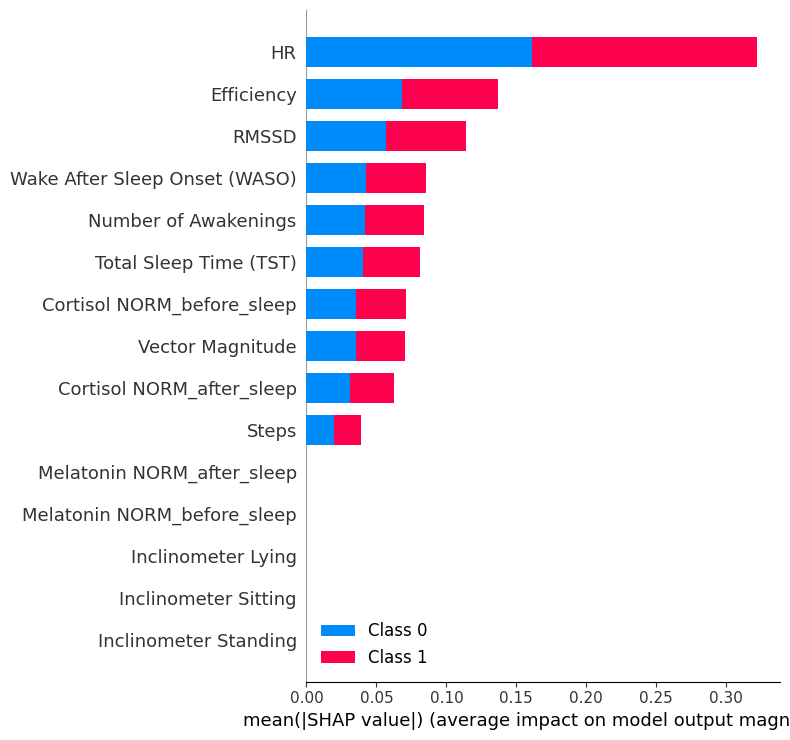

SHAP Summary for XGBoost:


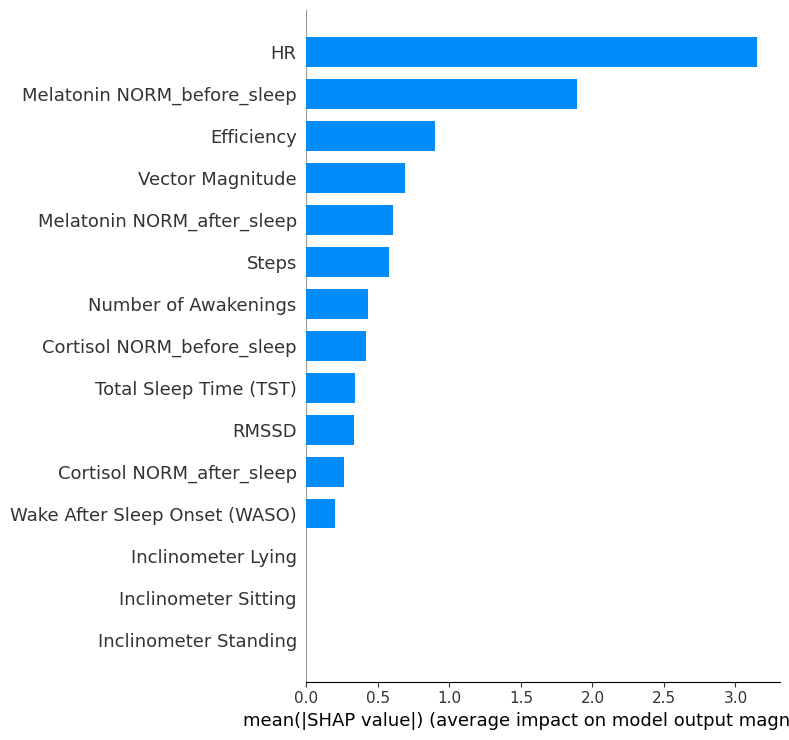

SHAP Summary for DecisionTree:


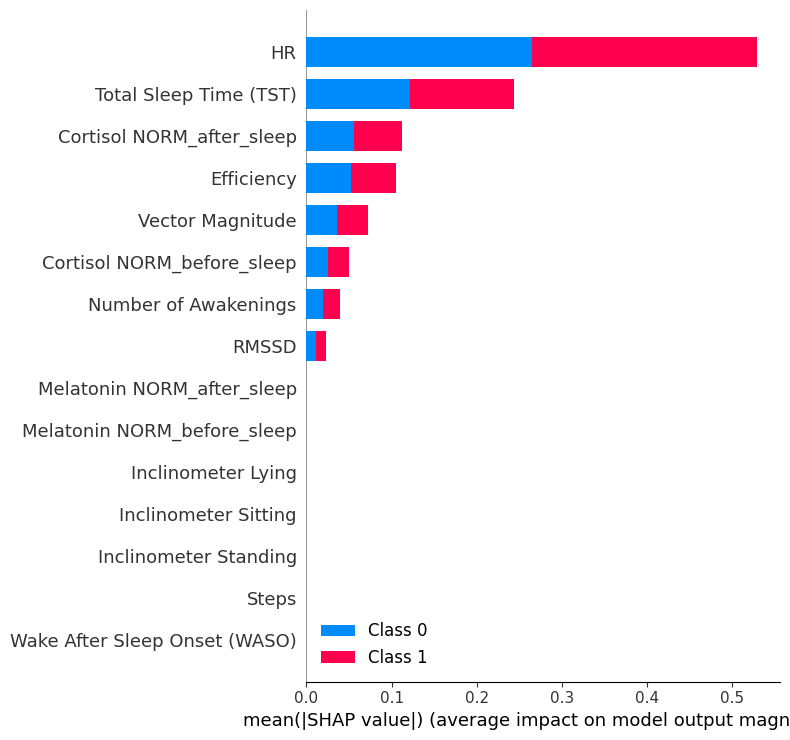

In [417]:
for model_name, shap_values in shap_values_dict.items():
    print(f"SHAP Summary for {model_name}:")
    shap.summary_plot(shap_values, X_test, plot_type='bar')